In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools
import pickle
import os
import json

In [6]:
2*np.arcsin(np.sqrt(1-1/3))

np.float64(1.9106332362490186)

In [3]:
def read_pickle_files_from_directory(directory):

    loaded_files = {}
    if not os.path.isdir(directory):
        print(f"Error: Directory '{directory}' not found.")
        return loaded_files

    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'rb') as file:
                    loaded_files[filename[:-4]] = pickle.load(file)
            except Exception as e:
                print(f"Error reading file '{filename}': {e}")
    return loaded_files

In [4]:
carpet_path = "/home/gari/Documents/QAOA/TestSample"
folder_path = "/home/gari/Documents/QAOA/OptimalSolutions"
graphs_str = ['5_graph_5','10_graph_12', '10_graph_14', '10_graph_15', '10_graph_18', '10_graph_25']
#graphs_str = ['25_graph_76', '25_graph_83', '25_graph_86']
loaded_data = read_pickle_files_from_directory(carpet_path)

In [4]:
graph_index = 0
graph_test = loaded_data[graphs_str[graph_index]]

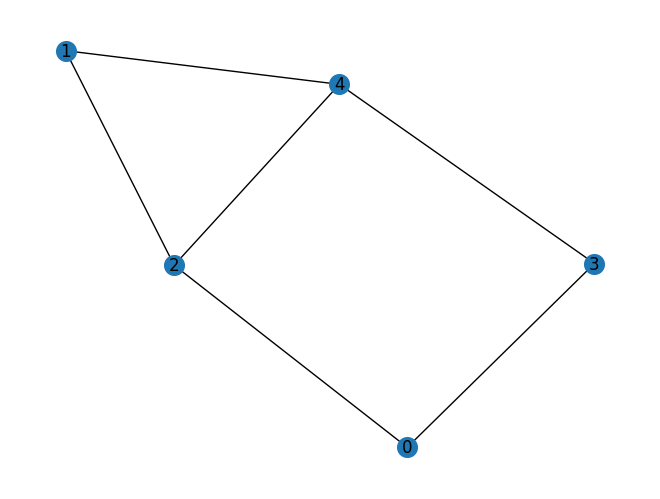

In [5]:
draw_graph(graph_test, node_size=200, with_labels=True, width=1)

In [5]:

def pygraph_to_adj_matrix(graph: rx.PyGraph) -> np.ndarray:
    n = graph.num_nodes()
    adj_matrix = np.zeros((n, n), dtype=int)

    for i, j, in graph.edge_list():
        adj_matrix[i][j] = 1
        adj_matrix[j][i] = 1  # because it's undirected

    return adj_matrix

In [11]:
import itertools
import numpy as np

def brute_force_all_cuts_sorted(adj_matrix):
    n = adj_matrix.shape[0]
    all_partitions = []

    for bits in itertools.product([0, 1], repeat=n):
        if all(b == 0 for b in bits) or all(b == 1 for b in bits):
            continue  # Skip trivial partitions

        cut_value = 0
        for i in range(n):
            for j in range(i+1, n):
                if bits[i] != bits[j] and adj_matrix[i, j] == 1:
                    cut_value += 1

        all_partitions.append((cut_value, bits))

    # Sort by cut value in descending order
    all_partitions.sort(reverse=True, key=lambda x: x[0])

    return all_partitions


os.makedirs(folder_path, exist_ok=True)
all_sorted_cuts = brute_force_all_cuts_sorted(pygraph_to_adj_matrix(graph_test))
file_path = os.path.join(folder_path, graphs_str[graph_index] + ".json")

# Prepare data in JSON format
data = [
    {"cut_value": value, "partition": partition}
    for value, partition in all_sorted_cuts
]

# Write JSON to file
with open(file_path, "w") as f:
    json.dump(data, f, indent=4)


In [ ]:

for i in range(len(graphs_str)):
    graph_name = graphs_str[i]
    graph_t = loaded_data[graph_name]
    all_sorted_cuts = brute_force_all_cuts_sorted(pygraph_to_adj_matrix(graph_t))

    file_path = os.path.join(folder_path, graph_name + "_solution.json")

    # Prepare data in JSON format
    data = [
        {"cut_value": value, "partition": partition}
        for value, partition in all_sorted_cuts
    ]

    # Write JSON to file
    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)



In [6]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        #paulis = ["I"] * 127
        #print(edge)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [7]:
cost_hamiltonians = [SparsePauliOp.from_list(build_max_cut_paulis(loaded_data[graphs_str[i]])) for i in range(len(graphs_str))]

In [8]:
result_data = []
for i in range(len(graphs_str)):
    file_name = graphs_str[i] +'_solution'
    file_path = os.path.join(folder_path, file_name+".json")
    with open(file_path, "r") as f:
        result_data.append(json.load(f))

In [9]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


## Auxiliary function helping to calculate the cost for a given state (sample output)

def calculate_cost(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced]).real


In [11]:
def average_energy_solution(graphs_str, result_data, hamiltonians):
    estimated_averages = []
    max_cut = [5, 12, 14, 15, 18, 25]
    for i, solutions in enumerate(result_data):
        hamiltonian = hamiltonians[i]
        costs = []

        for data in solutions:

            if data['cut_value'] == max_cut[i]:
                partition = data['partition']

                # Convert partition (list of 0/1) to integer bitstring
                bitstring = ''.join(str(bit) for bit in partition)
                bit_int = int(bitstring, 2)
                # Calculate energy (cost)
                cost = calculate_cost(bit_int, hamiltonian)
                costs.append(cost)

        # Average the costs for this graph
        avg_cost = np.mean(costs)
        estimated_averages.append(avg_cost)

    # Average across all graphs
    return estimated_averages

data = [
    {"cost_func": average_energy_solution(graphs_str, result_data, cost_hamiltonians)}
]

file_path = "/home/gari/Documents/QAOA/cost_function_mean.json"

with open(file_path, "w") as f:
    json.dump(data, f, indent=4)



